# Training
Este notebook inspirado en el colab anterior esta hecho para poder realizar entrenamiento simple

In [1]:
# !cd ../data && wget https://descargas.inf.santiago.usm.cl/train/4.tar.gz .

In [2]:
# !tar -xf ../data/4.tar.gz -C ../data

In [3]:
#!pip install scikit-optimize

# Codigo de Optimizacion
Definimos los parametros a modificar para realizar proceso de optimizacion

In [4]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import CheckpointSaver

from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D

from skopt.utils import use_named_args

# guardar informacion
import pickle
import os




# Codigo

In [23]:
import datetime

import matplotlib.pyplot as plt
from grav_lens import load_tf_dataset

import numpy as np
import tensorflow as tf

#data
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
# training and modeling
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D


def plot_images(images, cls_true, cls_pred=None, **kwargs):
    assert len(images) == len(cls_true) == 9
    img_shape = images[0].shape
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()



def log_dir_name(learning_rate, activation):
    """Helper function para usar tensorboard"""
    # The dir-name for the TensorBoard log-dir.
    s = "./logs/lr_{0:.0e}_act_{1}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       activation)

    return log_dir

import json
def save_hyperparameters(learning_rate, activation, counter):
    hyperparameters = {
        'learning_rate': learning_rate,
        'activation': activation
    }
    
    with open(f'hyperparameters_{counter}.json', 'w') as f:
        json.dump(hyperparameters, f)

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

def split_dataset(X_data, Y_data, val_split=0.2, test_split=0.1):
    # Dividir los datos en entrenamiento y conjunto temporal
    X_train, X_temp, Y_train, Y_temp = train_test_split(X_data, Y_data, test_size=val_split + test_split)
    
    # Dividir los datos temporales en validación y prueba
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=test_split / (val_split + test_split))
    
    # Convertir a dataset de TensorFlow
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    
    return train_dataset, val_dataset, test_dataset

def prepare_dataset(dataset, batch_size=32, shuffle_buffer=1000):
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)  # Mezclar datos
    dataset = dataset.batch(batch_size)  # Batching
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch para optimización
    return dataset

def get_datasets(data_index='4', max_files=100, home='..', batch_size=32, val_split=0.2, test_split=0.1):
    # Cargar el dataset
    dataset = load_tf_dataset(data_index=data_index, max_files=max_files, home=home)
    
    # Convertir el dataset en arrays Numpy para facilitar la división
    X_data = np.array([X.numpy() for X, _ in dataset])
    Y_data = np.array([Y.numpy() for _, Y in dataset])
    
    # Dividir el dataset en entrenamiento, validación y prueba
    train_dataset, val_dataset, test_dataset = split_dataset(X_data, Y_data, val_split, test_split)
    
    # Preparar cada dataset
    train_dataset = prepare_dataset(train_dataset, batch_size)
    val_dataset = prepare_dataset(val_dataset, batch_size)
    test_dataset = prepare_dataset(test_dataset, batch_size)
    
    return train_dataset, val_dataset, test_dataset

# Ejemplo de uso
train_dataset, val_dataset, test_dataset = get_datasets(data_index='4', max_files=100, home='..')

for X, Y in train_dataset.take(1):  # Mostrar un batch de entrenamiento
    print("Train X:", X.shape)
    print("Train Y:", Y.shape)

for X, Y in val_dataset.take(1):  # Mostrar un batch de validación
    print("Val X:", X.shape)
    print("Val Y:", Y.shape)

for X, Y in test_dataset.take(1):  # Mostrar un batch de prueba
    print("Test X:", X.shape)
    print("Test Y:", Y.shape)


Using data folder: ../data/4
Train X: (32, 128, 128, 3)
Train Y: (32, 128, 128, 1)
Val X: (20, 128, 128, 3)
Val Y: (20, 128, 128, 1)
Test X: (11, 128, 128, 3)
Test Y: (11, 128, 128, 1)


2024-08-13 12:40:44.884054: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-13 12:40:44.968694: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-13 12:40:45.036150: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
import tensorflow as tf

# Definir una pérdida personalizada que combine MAE y KL Divergence
def combined_loss(y_true, y_pred):
    mae_loss = tf.keras.losses.mae(y_true, y_pred)  # Usar la función abreviada mae()
    kl_loss = tf.keras.losses.kld(y_true, y_pred)   # Usar la función abreviada kld()
    return mae_loss + kl_loss  # Puedes ponderar las pérdidas si es necesario


def create_model(learning_rate=1e-4, activation="relu"):
    """
    Una arquitectura fija y jugamos con el learning rate
    Hyper-parameters:
        learning_rate:     Learning-rate for the optimizer.
        activation:        Activation function for hidden layers
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),  # Usar la forma original
        tf.keras.layers.Conv2D(32, (5, 5), activation=activation, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (5, 5), activation=activation, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (5, 5), activation=activation, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(1, (5, 5), activation=activation, padding='same')  # Salida con 1 canal
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=combined_loss)

    return model

def load_hyperparameters(counter):
    with open(f'hyperparameters_{counter}.json', 'r') as f:
        hyperparameters = json.load(f)
    return hyperparameters

def load_model_with_hyperparameters(counter):
    # Cargar los hiperparámetros
    hyperparameters = load_hyperparameters(counter)
    learning_rate = hyperparameters['learning_rate']
    activation = hyperparameters['activation']

    # Recrear el modelo con los hiperparámetros cargados
    model = create_model(learning_rate, activation)
    
    # Cargar los pesos del modelo
    model.load_weights(f'best_model_{counter}.weights.h5')

    return model

# Crear el modelo
model = create_model()
model.summary()




Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 128, 1)    │         3,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,721 (1.00 MB)

 Trainable params: 262,273 (1.00 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
# Definiendo la forma de pasar parametros a la funcion de optimizacion
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')
#dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_activation = Categorical(categories=['relu', 'sigmoid', 'tanh'],
                             name='activation')


dimensions = [dim_learning_rate, dim_activation]
dimension_names = [x.name for x in dimensions]
default_parameters = [1e-5, 'relu']

In [43]:
import time
# Inicializar best_accuracy
best_loss = float('inf')
verbose = 1
counter = 1

# Función objetivo
@use_named_args(dimensions=dimensions)
def F_objective(learning_rate, activation):
    """
    Una arquitectura fija y jugamos con el learning rate, activacion y batchs
    Hyper-parameters:
        learning_rate:      Ratio de aprendizaje para optimizacodres
        activation:         Acticion capas internas
        batch_size:         Organizacion del batch para adtos
    """
    # Crear el modelo
    model = create_model(learning_rate, activation)
    # prepared_dataset = prepare_dataset(train_dataset, batch_size)

    log_dir = log_dir_name(learning_rate, activation)
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True)


    # Entrenar el modelo con TensorBoard callback
    model.fit(train_dataset, epochs=15, verbose=verbose, callbacks=[tensorboard_callback])

    loss = model.evaluate(val_dataset, verbose=0)


    # Print the classification accuracy.
    print()
    print("loss: {0:.2%}".format(loss))
    print()

    # Guardamos la mejor precision
    global best_loss, counter

    if loss < best_loss:
        # Salvar modelo
        model.save_weights(f'best_model_{counter}.weights.h5')

        # Guardar hiperparámetros
        save_hyperparameters(learning_rate, activation, counter)

        
        print(f"Model weights and hyperparameters saved with ID: {counter}")
        counter += 1
        # Update the classification accuracy.
        best_loss = loss
    
    # Borrar el modelo y los hiperparametro de memoria
    del model
    # y reiniciar el grafo computacional
    K.clear_session()
    return loss  # Queremos maximizar la precisión, por lo que minimizamos -precisión

# Comprobar funcionamiento
# start_time = time.time()
# F_objective(x=default_parameters)
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Execution time: {execution_time_minutes:.2f} minutes")

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.6541
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.6241
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.5979
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.5777
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.5631
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.5602
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.5499
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.5441
Epoch 9/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.5335
Epoch 10/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.5291
Epoch 11/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.5233
Epoch 12/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.5201
Epoch 13/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.5086
Epoch 14/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.5065
Epoch 15/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.5034

loss: 37.36%

Mode

In [28]:
model = load_model_with_hyperparameters(1)

for X, Y in test_dataset.take(1):
    prediction = model.predict(X)

/home/ftrigo/Escritorio/gravlens/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


In [30]:
prediction.shape

(11, 128, 128, 1)

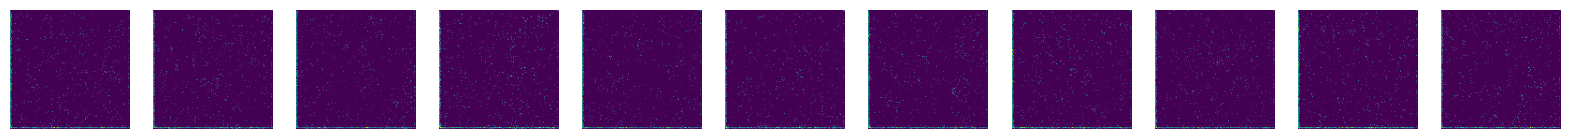

In [32]:
# Obtener la primera imagen de la predicción
predicted_images = prediction

# Configurar la figura
fig, axes = plt.subplots(1, predicted_images.shape[0], figsize=(20, 10))
axes = axes.flatten()

# Graficar cada imagen
for img, ax in zip(predicted_images, axes):
    ax.imshow(np.squeeze(img))  # Quitar el canal de color si es necesario
    ax.axis('off')

plt.show()

# GRAN MINIMIZACION

Codigo de minimizacion
Posiblemente tome bastante tiempo en ejecutarse

In [44]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index='4', max_files=2000, home='..')

Using data folder: ../data/4


In [45]:
# Crear un callback para guardar checkpoints
checkpoint_saver = CheckpointSaver("checkpoint.pkl", compress=9)

# Ejecutar la optimizacion
start_time = time.time()
res = gp_minimize(func=F_objective,
                    dimensions=dimensions,
                    acq_func='EI', # Expected Improvement.
                    n_calls=50,
                    x0=default_parameters,
                    callback=[checkpoint_saver])
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Execution time: {execution_time_minutes:.2f} minutes")

Epoch 1/15


44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.6069
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.5486
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.5130
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4922
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4770
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4640
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.4555
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4477
Epoch 9/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4426
Epoch 10/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.4349
Epoch 11/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4264
Epoch 12/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4219
Epoch 13/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4150
Epoch 14/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4090
Epoch 15/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.4047

loss: 37.12%

Model weights a

In [46]:

# Guardar el objeto res, para hacer estadistica despues
with open('optimization_results.pkl', 'wb') as f:
    pickle.dump(res, f)

# Hacer un plot
Veamos que tal lo ha hecho el modelo

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None)])
[0.003636525599163243, 'sigmoid']
Accuracy:  -0.03442706912755966


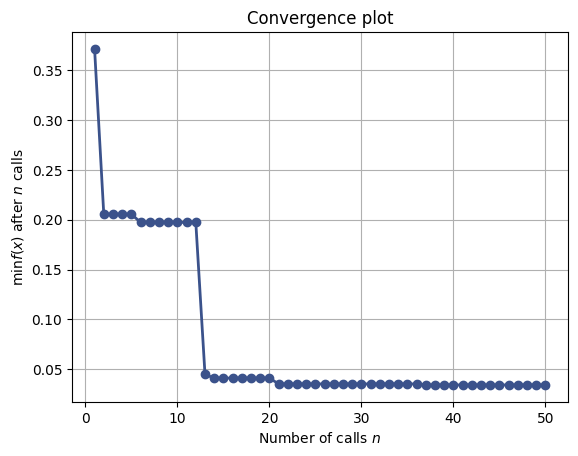

In [47]:
plot_convergence(res)
print(res.space)
print(res.x)
print("Accuracy: ", - res.fun)

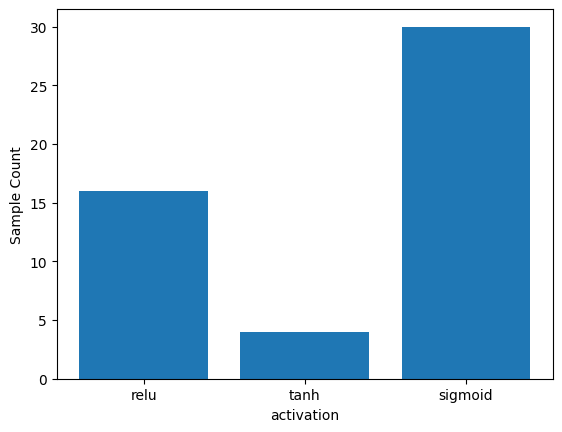

In [48]:
from skopt.plots import plot_histogram, plot_objective_2D

plot_histogram(result=res,  dimension_identifier='activation')
plt.show()

<Axes: >

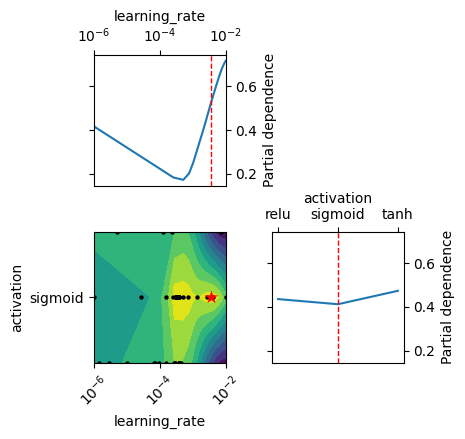

In [49]:
plot_objective(result=res, dimensions=dimension_names)

<Axes: >

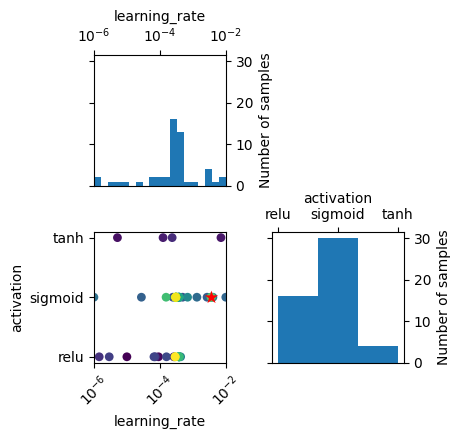

In [50]:
plot_evaluations(result=res, dimensions=dimension_names)